In [ ]:
!pip install pyAudioAnalysis
!pip install eyed3
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.3 MB 1.3 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=d1d2dde75acf036c9f59c7b212a25c6530760c682d8dc7c852f05c3b5a28079f
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 245 kB 4.1 MB/s 
     |████████████████████████████████| 242 kB 59.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import sys

In [ ]:
#Librerias
import eyed3
import pydub
from pyAudioAnalysis import ShortTermFeatures as aF
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import MidTermFeatures as mF 
import IPython

import numpy as np
import plotly.graph_objects as go
import plotly
import sklearn
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.formula.api import logit

# **CARGA DE DATOS**

Cargamos la ruta donde se encuentra nuestras imagenes enticketadas por el nombre

In [ ]:
Ravdess = "/content/drive/MyDrive/audio_speech_actors_01-24/"


In [ ]:
ravdess=os.listdir(Ravdess)

emotion=[]
path=[]
gender=[]
intensity=[]
for i in ravdess:
    actor=os.listdir(Ravdess+i)
    for f in actor:
        fsplit= f.split('.')[0]
        fsplit=fsplit.split('-')
        emotion.append(int(fsplit[2]))
        gend=int(fsplit[6])
        if gend%2==0:
            gender.append('Female')
        else:
            gender.append('Male')
        intensity.append(int(fsplit[3]))
        for sp in emotion:
            if sp=="1":
                intensity.append('Normal')
        path.append(Ravdess + i + '/' + f)
edf=pd.DataFrame(emotion, columns=['Emotions'])
pdf=pd.DataFrame(path, columns=['Path'])
gdf=pd.DataFrame(gender, columns=['Gender'])
idf=pd.DataFrame(intensity, columns=['Intensity'])

ravdess_df=pd.concat([edf, pdf, gdf, idf], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.Intensity.replace({1:'Normal', 2:'Strong'}, inplace=True)
ravdess_df.head()
ravdess_df.isnull()
ravdess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316 entries, 0 to 1315
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   1316 non-null   object
 1   Path       1316 non-null   object
 2   Gender     1316 non-null   object
 3   Intensity  1316 non-null   object
dtypes: object(4)
memory usage: 41.2+ KB


DataFrame con las rutas de los archivos de audio y las entiquetas con las emociones

In [ ]:
ravdess_df

,Emotions,Path,Gender,Intensity
0,calm,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Strong
1,sad,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Strong
2,sad,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Strong
3,calm,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Normal
4,angry,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Normal
...,...,...,...,...
1311,angry,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Normal
1312,surprise,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Normal
1313,sad,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Strong
1314,surprise,/content/drive/MyDrive/audio_speech_actors_01-...,Female,Strong


# **LIMPIEZA DE RUIDO**

**Funcion para Quitar ruido del Inicio y Final del Audio**

In [ ]:
import soundfile as sf
 
def QuitarRuidoINIFIN (RutaOrig , RutaDest):

  x , sr = librosa.load(RutaOrig)
  clip = librosa.effects. trim(x, top_db= 10)
  sf.write(RutaDest, clip[0], sr)


Ejecutamos la funcion creada que utiliza como datos de ingreso la ruta de origen de los archivos de audio y la ruta en donde se almacenará los archivos de salida.

In [ ]:
for n in range(ravdess_df.shape[0]):
  rutaOrigen=ravdess_df.Path[n]
  RutaDestino =rutaOrigen.replace('audio_speech_actors_01-24','SinRuidoExtremos_audio_speech_actors_01-24')#definimos la ruta en donde se guardada los archivos sin ruidos
  QuitarRuidoINIFIN(rutaOrigen ,RutaDestino)



**Funcion para retirar todos los ruidos**

In [ ]:
import soundfile as sf

def QuitarRuidoGENERAL (RutaOrig , RutaDest):

  x , sr = librosa.load(RutaOrig)
  clip = librosa.effects.split(x, top_db= 10)
  wav_data = []
  for c in clip:

    datos = x[c[0]: c[1]]
    wav_data.extend(datos)

  sf.write(RutaDest, wav_data, sr)


Ejecutamos la funcion creada que utiliza como datos de ingreso la ruta de origen de los archivos de audio y la ruta en donde se almacenará los archivos de salida.

In [ ]:
for n in range(ravdess_df.shape[0]):
  rutaOrigen=ravdess_df.Path[n]
  RutaDestino =rutaOrigen.replace('audio_speech_actors_01-24','SinRuidoGeneral_audio_speech_actors_01-24')
  QuitarRuidoGENERAL(rutaOrigen ,RutaDestino)

# **Prueba de audio**

**Con Ruido**

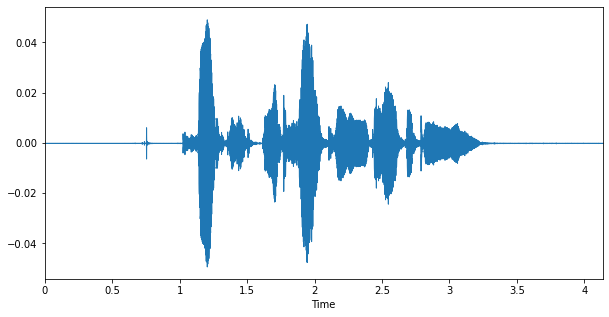

In [ ]:
rutaRuido = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_02/03-01-02-02-01-01-02.wav"
x , sr = librosa.load(rutaRuido)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr= sr)

In [ ]:
IPython.display.display(IPython.display.Audio(rutaRuido))

**Sin Ruido extremos**

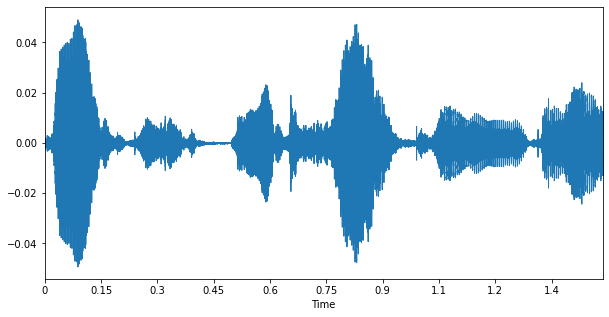

In [ ]:
rutaSinRuidoExt = "/content/drive/MyDrive/SinRuidoExtremos_audio_speech_actors_01-24/Actor_02/03-01-02-02-01-01-02.wav"
x , sr = librosa.load(rutaSinRuidoExt)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr= sr)

In [ ]:
IPython.display.display(IPython.display.Audio(rutaSinRuidoExt))

**Sin ruido general**

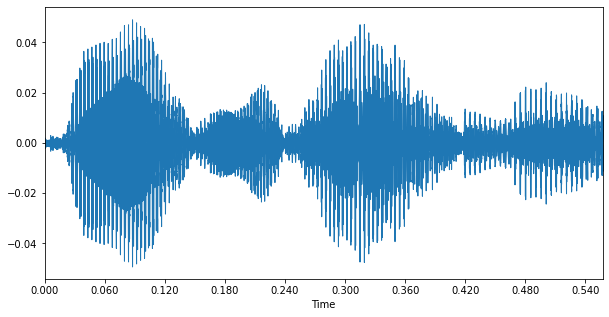

In [ ]:
rutaSinRuidoGen = "/content/drive/MyDrive/SinRuidoGeneral_audio_speech_actors_01-24/Actor_02/03-01-02-02-01-01-02.wav"
x , sr = librosa.load(rutaSinRuidoGen)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr= sr)

In [ ]:
IPython.display.display(IPython.display.Audio(rutaSinRuidoGen))

# =============================FIN========================================